<a href="https://colab.research.google.com/github/Bit-Slide/Kalmar_weather/blob/main/Kalmar_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import xarray as xr
import netCDF4 as nc

In [4]:
file_name = '/content/metno_meps_20220101_20250508.nc'
ds = xr.open_dataset(file_name)
print(ds)

<xarray.Dataset> Size: 357MB
Dimensions:                 (reference_time: 4849, valid_time: 67, point: 25)
Coordinates:
    latitude                (point) float64 200B ...
    longitude               (point) float64 200B ...
  * point                   (point) int64 200B 0 1 2 3 4 5 ... 19 20 21 22 23 24
  * reference_time          (reference_time) datetime64[ns] 39kB 2022-01-01 ....
  * valid_time              (valid_time) int64 536B 0 1 2 3 4 ... 62 63 64 65 66
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 32MB ...
    RelativeHumidity        (reference_time, valid_time, point) float32 32MB ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 65MB ...
    Temperature             (reference_time, valid_time, point) float32 32MB ...
    TotalPrecipitation      (reference_time, valid_time, point) float64 65MB ...
    WindDirection           (reference_time, valid_time, point) float32 32MB ...
    WindDirection:100       (

In [5]:
df = ds.to_dataframe()

df = df.reset_index()

# In the netcdf file, valid_time is an hour offset from reference_time
# Here we reconstruct valid_time into actual timestamps
df['valid_time'] = df['reference_time'] + pd.TimedeltaIndex(df['valid_time'],unit="hours")

# Recreate index: reference_time, valid_time, point
df.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(df['reference_time'].values),
    pd.to_datetime(df['valid_time'].values),
    df['point'].values
    ],
    names=['reference_time', 'valid_time', 'point']
)

print(df)

<ipython-input-5-812605cf5aad>:7: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df['valid_time'] = df['reference_time'] + pd.TimedeltaIndex(df['valid_time'],unit="hours")


                                         reference_time          valid_time  \
reference_time valid_time          point                                      
2022-01-01     2022-01-01 00:00:00 0         2022-01-01 2022-01-01 00:00:00   
                                   1         2022-01-01 2022-01-01 00:00:00   
                                   2         2022-01-01 2022-01-01 00:00:00   
                                   3         2022-01-01 2022-01-01 00:00:00   
                                   4         2022-01-01 2022-01-01 00:00:00   
...                                                 ...                 ...   
2025-05-08     2025-05-10 18:00:00 20        2025-05-08 2025-05-10 18:00:00   
                                   21        2025-05-08 2025-05-10 18:00:00   
                                   22        2025-05-08 2025-05-10 18:00:00   
                                   23        2025-05-08 2025-05-10 18:00:00   
                                   24        2025-05

<Axes: xlabel='valid_time'>

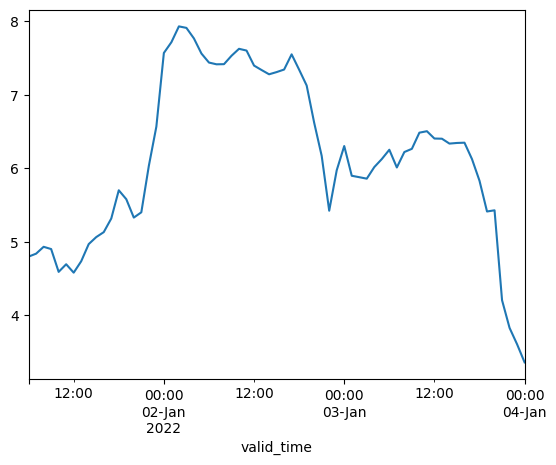

In [6]:
# Plotting temperature forecast with refernce time 2022-01-01 06:00 for point 0

df.loc['2022-01-01 06:00',:,0]['Temperature'].plot()

In [7]:
import xarray as xr
import pandas as pd
import numpy as np

# Kalmar's coordinates
kalmar_lat = 56.661389
kalmar_lon = 16.362778

# Extract latitude and longitude for each point from the dataset for calculation
point_lats = ds['latitude'].values
point_lons = ds['longitude'].values
point_indices = ds['point'].values

# Calculate Euclidean distance for each point to Kalmar
distances = np.sqrt((point_lats - kalmar_lat)**2 + (point_lons - kalmar_lon)**2)

# Find the index of the point closest to Kalmar
closest_point_idx_in_coords = np.argmin(distances)
closest_point_id = point_indices[closest_point_idx_in_coords]

print(f"Kalmar's Latitude: {kalmar_lat}, Longitude: {kalmar_lon}")
print(f"Closest point found in data: point={closest_point_id}")
print(f"Latitude of closest point: {point_lats[closest_point_idx_in_coords]}")
print(f"Longitude of closest point: {point_lons[closest_point_idx_in_coords]}")


# Filter the DataFrame for the closest point
filtered_df = df.loc[pd.IndexSlice[:, :, closest_point_id], :]

# Select only CloudCover and WindSpeed, and keep the time indices
result_df = filtered_df[['CloudCover', 'WindSpeed']]

print("\nFiltered data for Kalmar (CloudCover and WindSpeed):")
print(result_df)

Kalmar's Latitude: 56.661389, Longitude: 16.362778
Closest point found in data: point=14
Latitude of closest point: 56.703626
Longitude of closest point: 16.37611

Filtered data for Kalmar (CloudCover and WindSpeed):
                                          CloudCover  WindSpeed
reference_time valid_time          point                       
2022-01-01     2022-01-01 00:00:00 14       0.471359   5.465876
               2022-01-01 01:00:00 14       0.999969   3.643007
               2022-01-01 02:00:00 14       0.999725   3.310723
               2022-01-01 03:00:00 14       0.999481   3.449114
               2022-01-01 04:00:00 14       1.000000   3.728086
...                                              ...        ...
2025-05-08     2025-05-10 14:00:00 14       0.985333   2.402389
               2025-05-10 15:00:00 14       0.819622   2.350534
               2025-05-10 16:00:00 14       0.749321   3.113977
               2025-05-10 17:00:00 14       0.690736   3.529974
               

In [8]:
import numpy as np
import pandas as pd
import xarray as xr # Ensure xarray is imported at the beginning of your Colab notebook if not already

# Assuming 'ds' (xarray Dataset) and 'df' (pandas DataFrame) are already loaded and processed
# from your previous steps in the Colab notebook.
# For example, after running:
# file_name = '/content/metno_meps_20220101_20250508.nc'
# ds = xr.open_dataset(file_name)
# df = ds.to_dataframe()
# df = df.reset_index()
# df['valid_time'] = df['reference_time'] + pd.to_timedelta(df['valid_time'], unit="hours")
# df.index = pd.MultiIndex.from_arrays([
#     pd.to_datetime(df['reference_time'].values),
#     pd.to_datetime(df['valid_time'].values),
#     df['point'].values
#     ],
#     names=['reference_time', 'valid_time', 'point']
# )

# 1. Define Kalmar's coordinates
kalmar_lat = 56.661389
kalmar_lon = 16.362778

# 2. Extract unique latitude and longitude for each 'point' from the dataset
# 'ds' is better for this as it directly holds the coordinate data for each 'point'
point_lats = ds['latitude'].values
point_lons = ds['longitude'].values
point_indices = ds['point'].values

# 3. Calculate Euclidean distance for each point to Kalmar
# This is a good approximation for finding the closest point in a small area
distances = np.sqrt((point_lats - kalmar_lat)**2 + (point_lons - kalmar_lon)**2)

# 4. Find the 'point' index that corresponds to the minimum distance
closest_point_idx_in_coords = np.argmin(distances)
closest_point_id = point_indices[closest_point_idx_in_coords]

print(f"Kalmar's Latitude: {kalmar_lat}, Longitude: {kalmar_lon}")
print(f"Closest point found in data: point={closest_point_id}")
print(f"Latitude of closest point: {point_lats[closest_point_idx_in_coords]}")
print(f"Longitude of closest point: {point_lons[closest_point_idx_in_coords]}")

# 5. Filter the DataFrame for the closest point
# Use pd.IndexSlice to correctly select across multi-index levels
filtered_df_kalmar = df.loc[pd.IndexSlice[:, :, closest_point_id], :]

# 6. Select only 'CloudCover' and 'WindSpeed' columns
# The time indices (reference_time, valid_time) will be retained automatically
kalmar_data_subset = filtered_df_kalmar[['CloudCover', 'WindSpeed']]

print("\nFiltered data for Kalmar (CloudCover and WindSpeed):")
print(kalmar_data_subset)

# If you want to see the first few rows of the filtered data:
# print(kalmar_data_subset.head())

Kalmar's Latitude: 56.661389, Longitude: 16.362778
Closest point found in data: point=14
Latitude of closest point: 56.703626
Longitude of closest point: 16.37611

Filtered data for Kalmar (CloudCover and WindSpeed):
                                          CloudCover  WindSpeed
reference_time valid_time          point                       
2022-01-01     2022-01-01 00:00:00 14       0.471359   5.465876
               2022-01-01 01:00:00 14       0.999969   3.643007
               2022-01-01 02:00:00 14       0.999725   3.310723
               2022-01-01 03:00:00 14       0.999481   3.449114
               2022-01-01 04:00:00 14       1.000000   3.728086
...                                              ...        ...
2025-05-08     2025-05-10 14:00:00 14       0.985333   2.402389
               2025-05-10 15:00:00 14       0.819622   2.350534
               2025-05-10 16:00:00 14       0.749321   3.113977
               2025-05-10 17:00:00 14       0.690736   3.529974
               

In [9]:
# Assuming 'kalmar_data_subset' is the DataFrame you got from the previous step.

# Filter the DataFrame for data where 'valid_time' is in the year 2025
data_2025 = kalmar_data_subset.loc[pd.IndexSlice[:, '2025', :], :]

print("\nFiltered data for Kalmar (CloudCover and WindSpeed) for the year 2025:")
print(data_2025)

# To see the number of rows in the filtered data:
print(f"\nNumber of rows for 2025 data: {len(data_2025)}")


Filtered data for Kalmar (CloudCover and WindSpeed) for the year 2025:
                                               CloudCover  WindSpeed
reference_time      valid_time          point                       
2024-12-29 06:00:00 2025-01-01 00:00:00 14       0.998724  10.167387
2024-12-29 12:00:00 2025-01-01 00:00:00 14       0.998724   9.835181
                    2025-01-01 01:00:00 14       0.998724  10.419826
                    2025-01-01 02:00:00 14       0.998724  10.740067
                    2025-01-01 03:00:00 14       0.998724  11.515038
...                                                   ...        ...
2025-05-08 00:00:00 2025-05-10 14:00:00 14       0.985333   2.402389
                    2025-05-10 15:00:00 14       0.819622   2.350534
                    2025-05-10 16:00:00 14       0.749321   3.113977
                    2025-05-10 17:00:00 14       0.690736   3.529974
                    2025-05-10 18:00:00 14      -0.002237   3.486102

[34042 rows x 2 columns]

Numb

In [10]:
# Assuming 'data_2025' is the DataFrame you filtered in the previous step.

# Define the filename for your CSV file
output_csv_filename = 'kalmar_weather_2025.csv'

# Save the DataFrame to a CSV file
# index=True will include the MultiIndex (reference_time, valid_time, point) as columns in the CSV
data_2025.to_csv(output_csv_filename, index=True)

print(f"\nData successfully saved to '{output_csv_filename}'")
print("You can download this file from the Colab file browser (folder icon on the left).")


Data successfully saved to 'kalmar_weather_2025.csv'
You can download this file from the Colab file browser (folder icon on the left).
